# Clustering d'Images avec Scikit-learn et Visualisation avec Streamlit

Le clustering est une technique d'apprentissage non supervisé qui permet de regrouper des données similaires en différents groupes ou clusters. Dans le contexte de l'analyse d'images, le clustering peut être utilisé pour segmenter des images, détecter des objets ou des régions d'intérêt, et comprendre la structure des données d'image. Ce TP vous guidera à travers le processus de clustering d'un ensemble d'images de chiffres manuscrits en utilisant l'algorithme K-Means et l'extraction de caractéristiques HOG et d'histogrammes de niveaux de gris. Vous visualiserez ensuite les résultats du clustering à l'aide de la bibliothèque Streamlit.


À la fin de ce TP, vous aurez une compréhension pratique du processus de clustering d'images, de l'extraction de caractéristiques, de l'évaluation des performances et de la visualisation des résultats à l'aide de Streamlit. Ces compétences sont précieuses dans de nombreux domaines tels que la vision par ordinateur, le traitement d'images médicales, l'analyse de données d'imagerie satellitaire, et bien d'autres.


In [34]:
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
from sklearn import datasets
from matplotlib import pyplot as plt
import plotly.express as px

import glob
import cv2 as cv
import numpy as np

from features import *
from clustering import *
from utils import *
from constant import  PATH_OUTPUT, MODEL_CLUSTERING,PATH_DATA

In [74]:

path = glob.glob("../../data/test" + '/*/*.jpg')
labelImages = []
for img in path:
    n = cv.imread(img)
    if(n is not None):
        n = np.array(n, dtype=np.uint8)
        n = cv.cvtColor(n,cv.COLOR_BGR2RGB)
        imgSplit = img.split('/')
        labelImages.append([imgSplit[4],n])

labelImages = pd.DataFrame(labelImages, columns=['Label', 'Image'])
images = labelImages['Image']
images = images.to_numpy()

Labels_true = labelImages['Label']
labels_true = Labels_true.to_numpy()


In [9]:
print(images.shape)

(951,)


In [3]:
fig = px.imshow(images[0])
fig.show()


## Partie 1 : Création du modèle de clustering d'images
#### (fichier pipeline.py)

**1. Chargement des données d'images de chiffres manuscrits à partir du dataset Digits.**
   - Vous utiliserez le célèbre dataset Digitis qui contient des images de chiffres manuscrits. Ce dataset est souvent utilisé pour tester des algorithmes de reconnaissance de chiffres et d'apprentissage automatique.



**2. Extraction des caractéristiques HOG (Histogrammes de Gradients Orientés) et des histogrammes de niveaux de gris à partir des images.**
   - Les caractéristiques HOG capturent les informations de gradient et de bords dans les images, ce qui les rend utiles pour la reconnaissance d'objets et de formes.
   - Les histogrammes de niveaux de gris représentent la distribution des intensités de pixels dans l'image, fournissant des informations sur la texture et les motifs.

**TODO :**
   - Implémentez les fonctions `compute_hog_descriptors` et `compute_gray_histograms` dans  le fichier `features.py`, utilisez respectivement les fonctions `hog` de  la librairie `skimage` et  `calcHist` de `cv2`.
   - lien HOG : https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html
   - lien  histogrammes de niveaux de gris : https://pyimagesearch.com/2021/04/28/opencv-image-histograms-cv2-calchist/
   

In [4]:
def compute_color_histograms(images):
    """
    Calcule les histogrammes de niveau de gris pour les images MNIST.
    Input : images (list) : liste des images en niveaux de gris
    Output : descriptors (list) : liste des descripteurs d'histogrammes de niveau de gris
    """
    color = ('b','g','r')
    descriptors = []
    for image in images:
        image = image.astype(np.uint8)
        hsv_image = cv.cvtColor(image, cv.COLOR_RGB2HSV)
        hist = cv.calcHist([hsv_image],[0,1,2],None,[16,16,16],[0,180,0,256,0,256])
        descriptors.append(cv.normalize(hist,hist).flatten())
    return descriptors

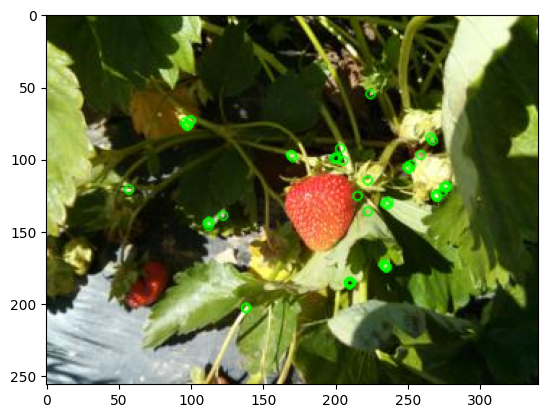

(50, 32)

In [51]:
image = images[97]
descriptors = []
orb = cv.ORB_create(50)  # Créer un détecteur ORB
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)  # Convertir l'image en niveaux de gris
keypoints = orb.detect(gray, None)  # Détecter les points d'intérêt ORB
kp, descriptor = orb.compute(gray, keypoints)  # Calculer les descripteurs ORB
#descriptors.append(descriptor.flatten())
img2 = cv.drawKeypoints(image, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()
descriptor.shape

In [52]:
def compute_ORB_descriptor(images, targeted_feature = 300):
    descriptors = []
    
    # ORB
    orb = cv.ORB_create(targeted_feature)  # Créer un détecteur ORB
    for image in images:
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)  # Convertir l'image en niveaux de gris
        keypoints = orb.detect(gray, None)  # Détecter les points d'intérêt ORB
        kp, descriptor = orb.compute(gray, keypoints)  # Calculer les descripteurs ORB
        descriptors.append(descriptor)
    
    #on met tous les descripteurs à la même taile pour cela on cherche le plus petit et on tronque les autres
    descriptors_resized = []
    for descriptor in descriptors:
        if descriptor.shape[0] < targeted_feature:
            # Si le descripteur est plus petit que la taille désirée, le remplir avec des zéros
            padded_descriptor = np.zeros((targeted_feature,32), dtype=descriptor.dtype)
            padded_descriptor[:descriptor.shape[0]] = descriptor
            descriptors_resized.append(cv.normalize(padded_descriptor,padded_descriptor).flatten())
        else:
            descriptors_resized.append(cv.normalize(descriptor,descriptor).flatten())


    return descriptors_resized




**3. Application de l'algorithme K-Means sur les caractéristiques extraites pour obtenir les clusters.**
   - L'algorithme K-Means est un algorithme de clustering populaire qui partitionne les données en K clusters en minimisant la somme des carrés des distances entre les points de données et les centroïdes des clusters.
   
   

 **TODO :**
   - Dans le fichier `clustering.py` implémentez les fonctions `initialize_centers()`, `nearest_cluster()` et `fit()` du KMeans.
   

In [53]:
number_cluster = 20

In [54]:
descriptors_color_hist = compute_color_histograms(images)
descriptors_ORB = compute_ORB_descriptor(images,50)

In [55]:
print(np.array(descriptors_color_hist).shape)
print(np.array(descriptors_ORB).shape)


(951, 4096)
(951, 1600)


In [80]:
descriptors_ORB_COLOR = np.concatenate((2*np.array(descriptors_ORB), descriptors_color_hist), axis=1)

In [81]:
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=number_cluster)
spectral.fit(np.array(descriptors_ORB_COLOR))
spectral.labels_

array([ 3, 19, 19,  1, 19,  9,  3,  6,  2,  5,  1,  4,  3, 11,  5,  3,  4,
       12, 12,  1,  1, 17,  8, 13, 19,  2,  3,  4,  3,  3, 16,  4, 16, 13,
       12, 18, 16,  6, 19,  3,  3,  1,  3,  3,  3,  7, 16, 17, 18,  1, 11,
        5, 17, 12, 17,  1,  3,  3,  2, 13, 15,  3, 10,  3,  4, 19,  7,  3,
        1, 12,  3, 12, 17,  3,  9,  7,  3,  1,  2,  3, 12,  1, 18,  3, 18,
       11, 17, 19, 11, 17,  3, 10,  1, 12,  4, 11, 17,  0,  7,  9, 12, 15,
        7,  1,  6, 18,  3,  5,  7,  7,  1, 16,  1, 11, 15,  5, 18,  5, 15,
        1,  8,  3,  9,  1,  1, 11, 10,  3, 16, 18,  5,  6,  3,  3,  8,  3,
       11,  3,  6, 11,  6,  5,  3,  2,  7,  7, 11,  7,  5, 11,  2, 18, 11,
       11,  3,  9,  1, 11, 15,  1, 11,  3,  6,  4,  1,  1,  1,  3, 18,  1,
        1,  3,  1, 18, 11, 18,  1,  5,  5, 10, 11, 13, 16,  1, 17, 11, 17,
        4, 17,  6, 18,  5,  6,  3,  2,  8,  2,  6,  5, 17,  9,  4,  8,  6,
       13, 17,  5,  3, 15,  9, 15,  9,  6,  5,  2,  6, 11,  5, 14,  1,  3,
       17, 18,  9, 16, 18

Cluster 3


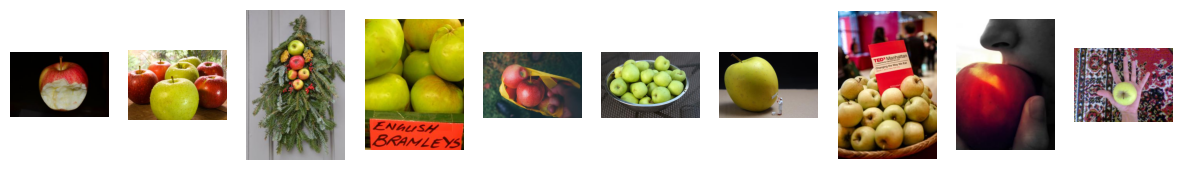

Cluster 19


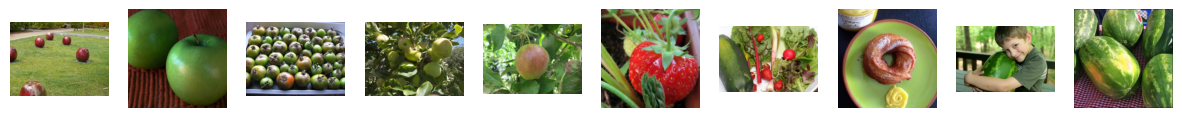

Cluster 1


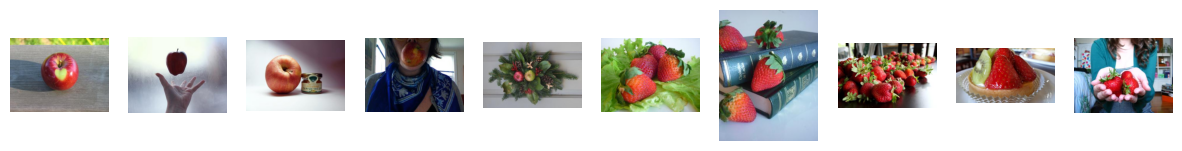

Cluster 9


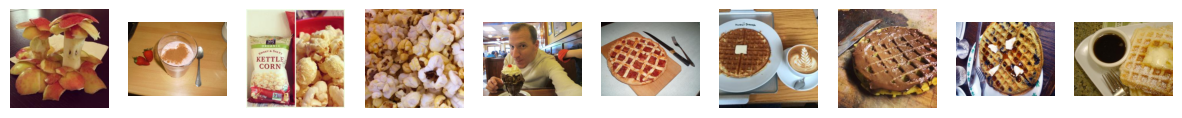

Cluster 6


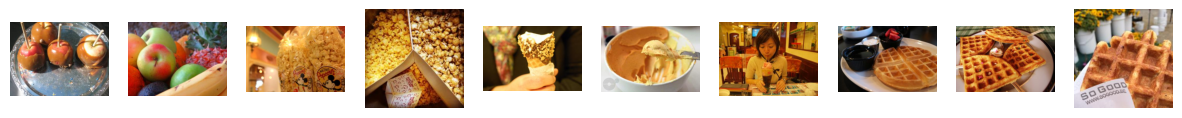

Cluster 2


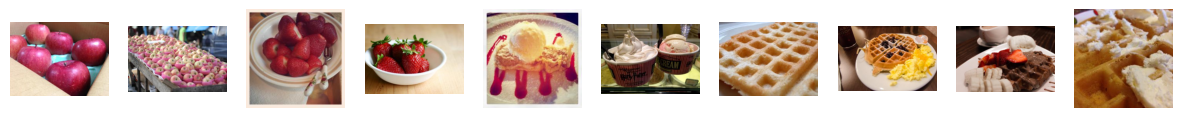

Cluster 5


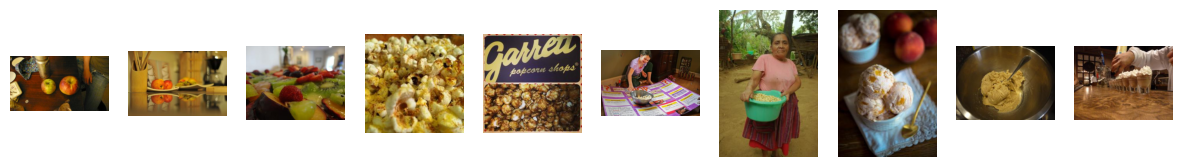

Cluster 4


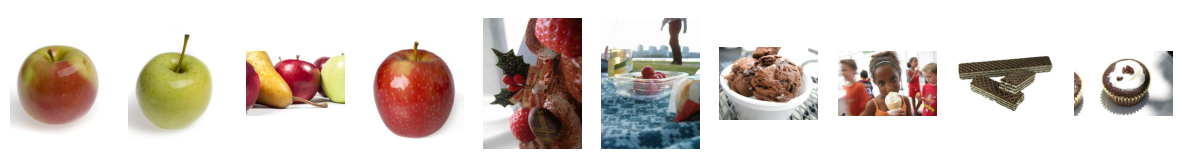

Cluster 11


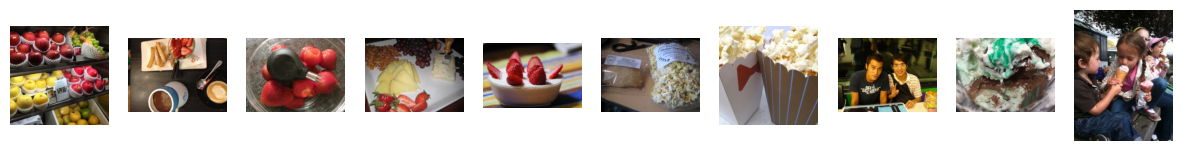

Cluster 12


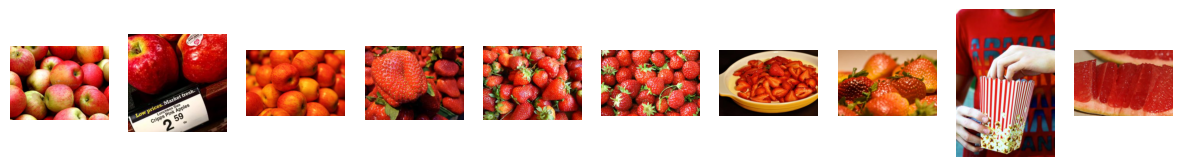

Cluster 17


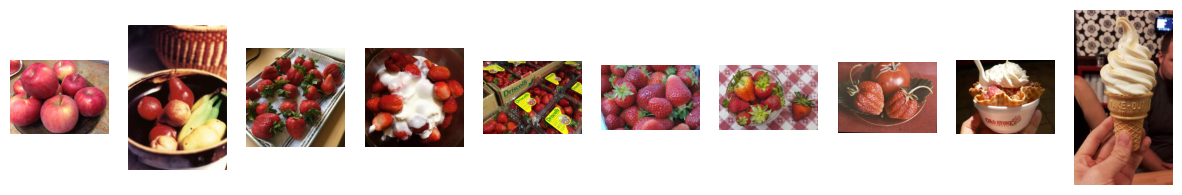

Cluster 8


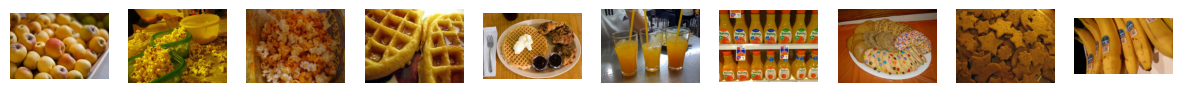

Cluster 13


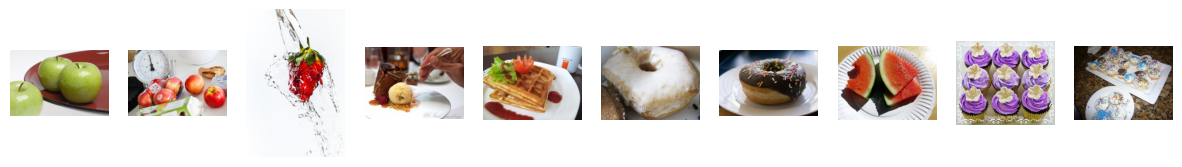

Cluster 16


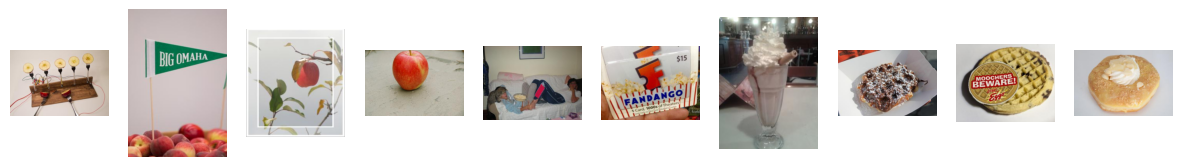

Cluster 18


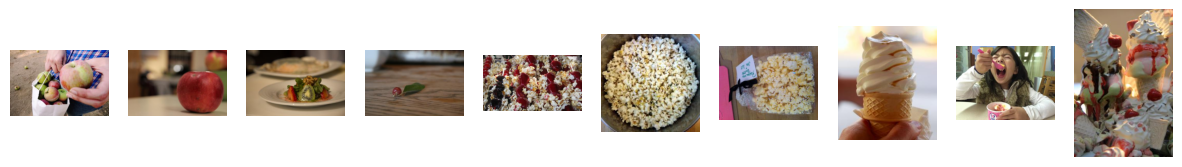

Cluster 7


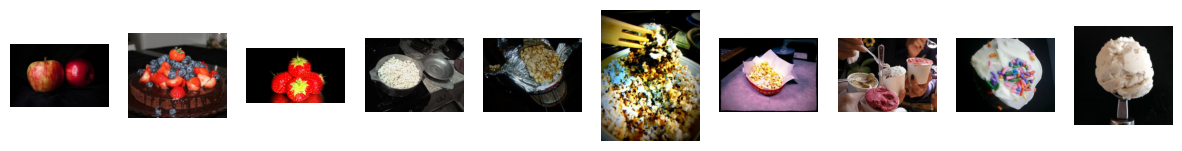

Cluster 15


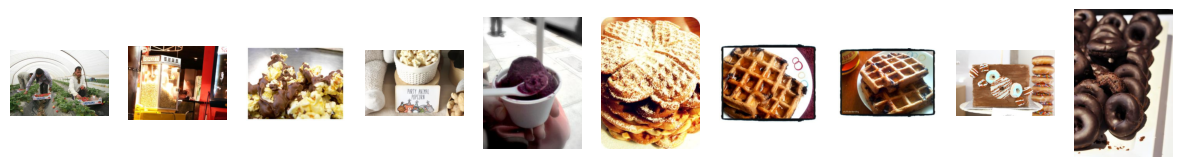

Cluster 10


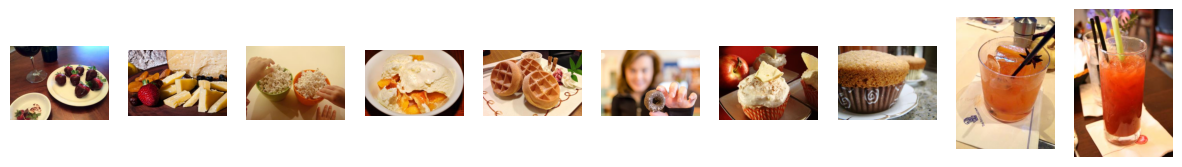

Cluster 0


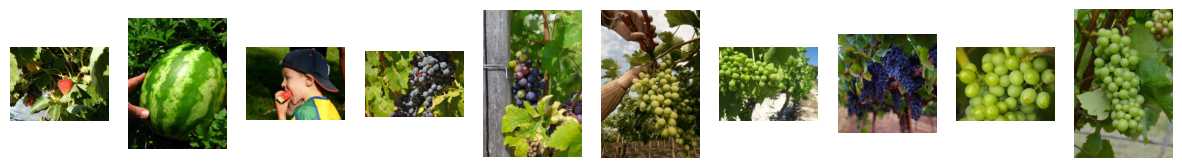

Cluster 14


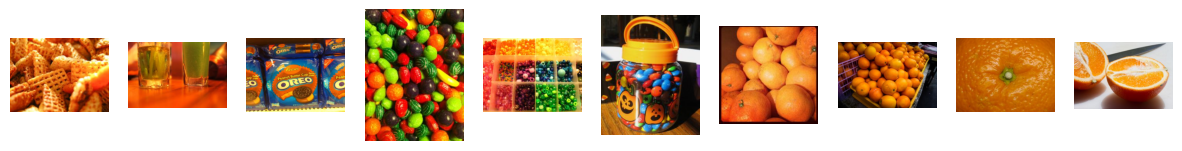

In [82]:
def afficher_clusters(images, labels, max_image = 10):
    # Créer un dictionnaire pour regrouper les images par cluster
    clusters = {}
    for label, image in zip(labels, images):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(image)

    # Afficher chaque cluster
    for label, cluster_images in clusters.items():
        print("Cluster", label)
        if len(cluster_images) == 1:
            # Si le cluster contient une seule image, utiliser une liste pour stocker l'objet Axes
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.imshow(cluster_images[0])
            ax.axis('off')
            plt.show()
        
        elif(len(cluster_images) < max_image):
            # Sinon, utiliser subplots normalement
            fig, axes = plt.subplots(1, len(cluster_images), figsize=(15, 15))
            for i, image in enumerate(cluster_images):
                
                axes[i].imshow(image)
                axes[i].axis('off')
            plt.show()
        else:
            # Sinon, utiliser subplots limité à 10
            fig, axes = plt.subplots(1, max_image, figsize=(15, 15))
            for i, image in enumerate(cluster_images):
                if(i == max_image):
                    break
                axes[i].imshow(image)
                axes[i].axis('off')
            plt.show()
            

afficher_clusters(images, spectral.labels_,10)

**4. Évaluation des performances du clustering en utilisant des métriques**
- Score AMI (Adjusted Mutual Information) :
    Le score AMI renvoie une valeur de 1 lorsque les deux partitions sont identiques (c'est-à-dire parfaitement appariées). Les partitions aléatoires (étiquetages indépendants) ont un score attendu autour de 0.
    

In [83]:

print("\n\n##### Résultat ######")
metric_hist = show_metric(labels_true, spectral.labels_, descriptors_ORB_COLOR, bool_show=True, name_descriptor="COLOR ORB", bool_return=True)
print("\n\n")
#metric_hog = show_metric(labels_true, kmeans_hog.labels_, descriptors_hog,bool_show=True, name_descriptor="HOG", bool_return=True)




##### Résultat ######


########## Métrique descripteur : COLOR ORB
Adjusted Mutual Information: 0.06874976433275475
silhouette_score: 0.041401688009500504





**5. Conversion des données de clustering au format requis pour la visualisation avec Streamlit.**

**TODO :**
- Dans le fichier `utils.py`, implémenter la fonction `conversion_3d` afin de convertir un vecteur de dimension n vers une dimension 3 pour a visualisation.
- Lien : https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [ ]:
list_dict = [metric_hist,metric_hog]
df_metric = pd.DataFrame(list_dict)

scaler = StandardScaler()
descriptors_hist_norm = scaler.fit_transform(descriptors_hist)
descriptors_hog_norm = scaler.fit_transform(descriptors_hog)

#conversion vers un format 3D pour la visualisation
x_3d_hist = conversion_3d(descriptors_hist_norm)
x_3d_hog = conversion_3d(descriptors_hog_norm)

# création des dataframe pour la sauvegarde des données pour la visualisation
df_hist = create_df_to_export(x_3d_hist, labels_true, kmeans_hist.labels_)
df_hog = create_df_to_export(x_3d_hog, labels_true, kmeans_hog.labels_)

# Vérifie si le dossier existe déjà
if not os.path.exists(PATH_OUTPUT):
    # Crée le dossier
    os.makedirs(PATH_OUTPUT)

# sauvegarde des données
df_hist.to_excel(PATH_OUTPUT+"/save_clustering_hist_kmeans.xlsx")
df_hog.to_excel(PATH_OUTPUT+"/save_clustering_hog_kmeans.xlsx")
df_metric.to_excel(PATH_OUTPUT+"/save_metric.xlsx")




***6. Création du fichier pipeline.py***
- Mettez au propre le code dans le fichier pipeline.py
- Puis exécutez :  `python pipeline.py `


***7. Analyse des résultats***
- Que penseez-vous des résultats que vous avez obtenu ?
- Relancer toute la pipeline avec un pré-traitement des images, comme augmenter le contrasse afin faire sortir la forme des objets. Et que remarquez-vous ?


## Partie 2 : Visualisation des résultats du clustering avec Streamlit
### (fichier dashboad_clustering.py)

Cette partie constituera le rendu final du TP. Nous développerons une application Streamlit pour visualiser et analyser les résultats du clustering.

L'application permettra de :

***1. Visualisation 3D du clustering***
- Nous créerons une visualisation 3D interactive des clusters obtenus, avec la possibilité de mettre en évidence un cluster spécifique et d'afficher des exemples d'images appartenant à ce cluster.

***TODO :***
- Utilizer la fonction `scatter_3d()` pour faire un plot 3D du clustering.
- lien : https://plotly.com/python/3d-scatter-plots/




In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px


***2. Métriques d'évaluation***
- Nous calculerons et afficherons diverses métriques d'évaluation, telles que le score AMI (Adjusted Mutual Information), pour quantifier la qualité du clustering obtenu avec chaque descripteur.

***TODO :***
- Utilisez la fonction `px.bar()` pour afficher un histogramme du score AMI.
- lien : https://plotly.com/python/horizontal-bar-charts/

In [ ]:
graph_size = 300


In [ ]:
df_metric

ami       ari  silhouette  homogeneity  completeness  v_measure  \
0  0.134182  0.068122    0.063914     0.141543      0.144184   0.142851   
1  0.415635  0.314030    0.110121     0.417808      0.425218   0.421480   

    jaccard descriptor name_model  
0  0.057647  HISTOGRAM     kmeans  
1  0.081767        HOG     kmeans

***3. Finalisation du fichier dashboard_clustering.py***

***TODO :***
- Ajoutez les graphiques dans le fichier, puis lancez la commande :  `streamlit run dashboard_clustering.py `